In [1]:
# Import modules
from __future__ import print_function
import pickle
import os
import scipy.io
from scipy import stats
import scipy.stats as st

import pandas as pd
from numpy import *

import numpy as np
from matplotlib import pyplot as plt
from scipy import stats
import pandas as pd
import argparse
from sklearn.model_selection import GridSearchCV, cross_val_score,cross_val_predict,StratifiedKFold
from sklearn.feature_selection import SelectFromModel
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score,confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc,f1_score
##read the data and clean data
def argumentparser():
    parser = argparse.ArgumentParser(description='PyTorch Connectome CNN')
    # hyper-parameters
    parser.add_argument('--dataset', type=int, default=1, help='select a dataset (1:connectome, 2: connectome + morphometry)')
    return parser
def data_fetch_clean(file,type):
    #os.getcwd()
    #os.chdir('../braindata')
    dd =pd.read_csv(file,header=0)
    print(dd.shape)
    import csv

    with open(file, 'r') as f:
        d_reader = csv.DictReader(f)

        #get fieldnames from DictReader object and store in list
        headers = d_reader.fieldnames
    data=np.array(dd)
    #print(data.shape)
    idx_IN_columns = np.append(np.array([3,4]),np.array(range(11,data.shape[1])))
    print(idx_IN_columns)
    X=data[:,idx_IN_columns]
    #features=data[:,11:data.shape[1]]
    #features = features.transpose()
    X = stats.zscore(X)
    #print(features.shape)
    y=data[:,type]
    #5: ad-smi / 6:mci-smi / 7:adonly-smi / 8:ad-mci / 9:adonly-mci / 10:adonly - adwithsmallvv


    ind_num=np.isnan(y)
    # print(ind_num.shape)


    y_no_nan = y[~ind_num]

    X_no_nan = X[~ind_num,:]

           # print(y.shape)

    y=y_no_nan
    X=X_no_nan
    feature_num_all=[]
    lr_all_feature=[]
    svm_all_feature=[]
    lr_fls_feature=[]
    svm_fls_feature=[]
    base_labels= []

    np.isnan(X).any()

    X[np.isnan(X)] = np.median(X[~np.isnan(X)])
    return X,y

#classification and cross validation 

In [2]:
def clf_randomforest(X,y,name,filename):
    all_TP = []
    all_TN = []
    all_FP = []
    all_FN = []

    all_acc = []
    all_sen = []
    all_spec = []
    all_auc = []

    all_roc_label = []
    all_roc_pred = []
    all_roc_prob = []
    n_fold = 3
    rs_list=[33994,31358,27381,8642,7012,42023,44642,44002,30706,12571]
    for rs in rs_list:
        print('********random seed:{}'.format(rs))


      

        inner_cv = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=rs)
        outer_cv = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=rs)

        scaler = StandardScaler()
        scaler.fit(X)
        X = scaler.transform(X)
        avg_auc = []
        avg_acc = []
        avg_TP = []
        avg_TN = []
        avg_FP = []
        avg_FN = []
        avg_sen = []
        avg_spec = []
     
        roc_label = []
        roc_pred = []
        roc_prob = []
        for train_index, test_index in outer_cv.split(X, y):
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]
            # 'featureExtract__n_estimators': np.arange(10, 100, 10),
            params = {'randomforest__min_samples_leaf': np.arange(1, 51, 5),
                      'randomforest__n_estimators': np.arange(10, 500, 10)}
            # clf_m = RandomForestClassifier(random_state=0)

            pipe = Pipeline([
                ('featureExtract', SelectFromModel(ExtraTreesClassifier())),
                ('randomforest', RandomForestClassifier())
            ])

            clf = GridSearchCV(estimator=pipe, param_grid=params, cv=inner_cv, scoring='accuracy',n_jobs=-1)
            clf.fit(X_train, y_train)

            fs = clf.best_estimator_.named_steps['featureExtract']
            mask = fs.get_support()
            y_pred = clf.predict(X_test)
            y_prob = clf.predict_proba(X_test)
          #  roc_pred = clf.predict_proba(X_test)

            acc = accuracy_score(y_test, y_pred)
            auc = roc_auc_score(y_test, y_prob[:, 1])

            roc_label = np.append(roc_label, y_test)
            roc_pred = np.append(roc_pred, y_pred)
            roc_prob = np.append(roc_prob, y_prob[:, 1])


            conf_mat = confusion_matrix(y_test, y_pred)

            TP = conf_mat[0][0]
            FP = conf_mat[0][1]
            FN = conf_mat[1][0]
            TN = conf_mat[1][1]

            avg_TP = np.append(avg_TP, TP)
            avg_TN = np.append(avg_TN, TN)
            avg_FP = np.append(avg_FP, FP)
            avg_FN = np.append(avg_FN, FN)

            avg_acc = np.append(avg_acc, acc)

            print(TP, FP, FN, TN)
            sen = TP / (TP + FN)
            spec = TN / (TN + FP)

            avg_sen = np.append(avg_sen, sen)
            avg_spec = np.append(avg_spec, spec)
            avg_auc = np.append(avg_auc, auc)
        
#             print('Accuracy:{},AUC:{}'.format(acc, auc))
#             print('Sensitivity:{},Specificity:{}'.format(sen, spec))
#             print('Accuracy:{},AUC:{}'.format(acc, auc))
#             print('Sensitivity:{},Specificity:{}'.format(sen, spec))
        all_TP = np.append(all_TP, avg_TP)
        all_TN = np.append(all_TN, avg_TN)
        all_FP = np.append(all_FP, avg_FP)
        all_FN = np.append(all_FN, avg_FN)

        all_acc = np.append(all_acc, avg_acc)
        all_sen = np.append(all_sen, avg_sen)
        all_spec = np.append(all_spec, avg_spec)
        all_auc = np.append(all_auc, avg_auc)

        all_roc_label = np.append(all_roc_label, roc_label)
        all_roc_pred = np.append(all_roc_pred, roc_pred)
        all_roc_prob = np.append(all_roc_prob, roc_prob)

        print("Accuracy Avg: {}".format(np.mean(avg_acc)))
        print("Accuracy Standard Deviation: {}".format(np.std(avg_acc)))
        print("Sensitivity Avg: {}".format(np.mean(avg_sen)))
        print("Sensitivity Standard Deviation: {}".format(np.std(avg_sen)))
        print("Specificity Avg: {}".format(np.mean(avg_spec)))
        print("Specificity Standard Deviation: {}".format(np.std(avg_spec)))

        #if dataset == 1:
#     pickle.dump(all_roc_label, open('roc_label_'+name+'.p', "wb"))
#     pickle.dump(all_roc_pred, open('roc_pred_'+name+'.p', "wb"))
#     pickle.dump(all_roc_prob, open('roc_prob_'+name+'.p', "wb"))
    acc_CI=st.t.interval(0.95, len(all_acc)-1, loc=np.mean(all_acc), scale=st.sem(all_acc))
    sen_CI=st.t.interval(0.95, len(all_sen)-1, loc=np.mean(all_sen), scale=st.sem(all_sen))
    spec_CI=st.t.interval(0.95, len(all_spec)-1, loc=np.mean(all_spec), scale=st.sem(all_spec))
    auc_CI=st.t.interval(0.95, len(all_auc)-1, loc=np.mean(all_auc), scale=st.sem(all_auc))
    import os
    
    if not os.path.exists('../imgs3_idp/'+filename):
        os.makedirs('../imgs3_idp/'+filename)
    txt_name='../imgs3_idp/' + filename+'/'+name +  '.txt'
    print("RF_ACC={a}, 95%CI={l}-{u}".format(a=np.mean(all_acc), l=acc_CI[0],u=acc_CI[1]),file=open(txt_name, "a"))
    print("RF_AUC={a}, 95%CI={l}-{u}".format(a=np.mean(all_auc), l=auc_CI[0],u=auc_CI[1]),file=open(txt_name, "a"))
    print("RF_SENSITIVITY={a}, 95%CI={l}-{u}".format(a=np.mean(all_sen), l=sen_CI[0],u=sen_CI[1]),file=open(txt_name, "a"))
    print("RF_SPECIFICITY={a}, 95%CI={l}-{u}".format(a=np.mean(all_spec), l=spec_CI[0],u=spec_CI[1]),file=open(txt_name, "a"))

    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    fpr, tpr, _ = roc_curve(all_roc_label, all_roc_prob)
    #auc = roc_auc_score(all_roc_label, all_roc_prob)

    plt.figure()

    plt.plot(fpr, tpr, lw=2, label='random forest (AUC = %0.2f)' % np.mean(all_auc))
    plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
    plt.xlim([-0.01, 1.01])
    plt.ylim([-0.01, 1.01])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(filename)
    plt.legend(loc="lower right") 
    #plt.savefig('10x_Combined_ROC.eps')
    roc_name='../imgs3_idp/' + filename+'/'+name +  '.pdf'
    plt.savefig(roc_name)
    plt.show()

    

In [3]:
save_name=["AD vs SMC","MCI vs SMC","ADonly vs SMC","AD vs MCI","ADonly vs MCI","ADonly vs ADwithsmallvv"]


In [4]:
# filename="comine_new.csv"
# cwd=os.getcwd()
# cwd

# # os.chdir('../data/adni')
# import pandas as pd
# pd.read_csv('combine_new.csv')

(208, 34657)
[    3     4    11 ... 34654 34655 34656]


/Users/posnerlab/miniconda3/lib/python3.6/site-packages/scipy/stats/stats.py:2253: RuntimeWarning: invalid value encountered in true_divide
  return (a - mns) / sstd


********random seed:33994
3 1 0 7
4 0 0 7
4 0 1 5
3 1 0 6
2 2 2 4
3 1 1 5
1 2 0 6
2 1 0 6
2 1 2 4
3 0 1 5
Accuracy Avg: 0.8331313131313131
Accuracy Standard Deviation: 0.11618866615221292
Sensitivity Avg: 0.8300000000000001
Sensitivity Standard Deviation: 0.19390719429665315
Specificity Avg: 0.8639285714285714
Specificity Standard Deviation: 0.10614889480574315


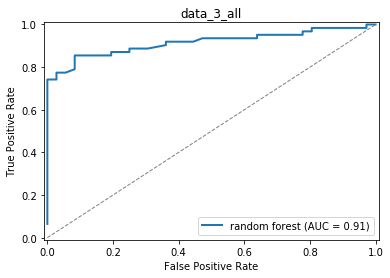

(208, 34657)
[    3     4    11 ... 34654 34655 34656]


/Users/posnerlab/miniconda3/lib/python3.6/site-packages/scipy/stats/stats.py:2253: RuntimeWarning: invalid value encountered in true_divide
  return (a - mns) / sstd


********random seed:33994
2 5 2 9
3 4 1 10
2 4 0 11
3 3 0 11
5 1 0 11
4 2 0 11
2 4 0 11
2 4 0 11
4 2 0 11
3 3 2 9
Accuracy Avg: 0.7862745098039216
Accuracy Standard Deviation: 0.09299898003011585
Sensitivity Avg: 0.885
Sensitivity Standard Deviation: 0.18445866745696715
Specificity Avg: 0.7701831501831502
Specificity Standard Deviation: 0.0755375748241947


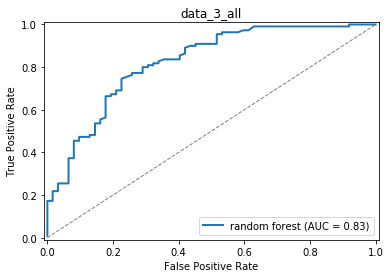

(208, 34657)
[    3     4    11 ... 34654 34655 34656]


/Users/posnerlab/miniconda3/lib/python3.6/site-packages/scipy/stats/stats.py:2253: RuntimeWarning: invalid value encountered in true_divide
  return (a - mns) / sstd


********random seed:33994
4 0 1 7
4 0 0 8
4 0 0 8
4 0 0 8
4 0 0 8
4 0 0 8
2 1 0 8
3 0 0 8
3 0 0 8
3 0 1 6
Accuracy Avg: 0.9725757575757576
Accuracy Standard Deviation: 0.04205712368781967
Sensitivity Avg: 0.9550000000000001
Sensitivity Standard Deviation: 0.09069178573608527
Specificity Avg: 0.9888888888888889
Specificity Standard Deviation: 0.03333333333333335


/Users/posnerlab/miniconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1910: RuntimeWarning: invalid value encountered in multiply
  lower_bound = self.a * scale + loc
/Users/posnerlab/miniconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1911: RuntimeWarning: invalid value encountered in multiply
  upper_bound = self.b * scale + loc


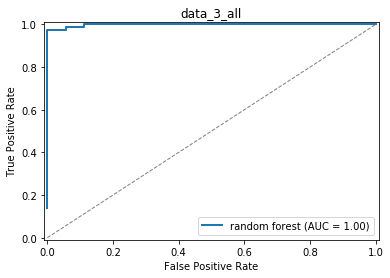

(208, 34657)
[    3     4    11 ... 34654 34655 34656]


/Users/posnerlab/miniconda3/lib/python3.6/site-packages/scipy/stats/stats.py:2253: RuntimeWarning: invalid value encountered in true_divide
  return (a - mns) / sstd


********random seed:33994
2 5 2 6
6 1 0 8
3 3 0 8
4 2 0 8
5 1 1 7
5 1 1 7
2 4 2 6
1 5 1 7
4 2 1 7
4 2 2 5
Accuracy Avg: 0.7444688644688645
Accuracy Standard Deviation: 0.1357730935945081
Sensitivity Avg: 0.7633333333333334
Sensitivity Standard Deviation: 0.1991370270832513
Specificity Avg: 0.7387012987012987
Specificity Standard Deviation: 0.12101395860287145


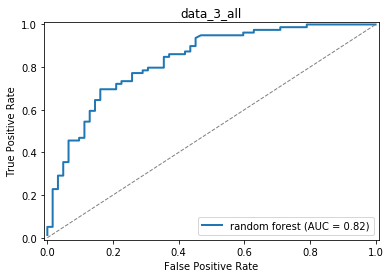

(208, 34657)
[    3     4    11 ... 34654 34655 34656]
********random seed:33994


/Users/posnerlab/miniconda3/lib/python3.6/site-packages/scipy/stats/stats.py:2253: RuntimeWarning: invalid value encountered in true_divide
  return (a - mns) / sstd


2 2 0 8
0 3 0 8


/Users/posnerlab/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:86: RuntimeWarning: invalid value encountered in long_scalars


0 3 0 8


/Users/posnerlab/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:86: RuntimeWarning: invalid value encountered in long_scalars


1 2 0 8
1 2 1 7
0 3 0 8


/Users/posnerlab/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:86: RuntimeWarning: invalid value encountered in long_scalars


1 2 0 8
0 3 0 8


/Users/posnerlab/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:86: RuntimeWarning: invalid value encountered in long_scalars


0 3 0 8


/Users/posnerlab/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:86: RuntimeWarning: invalid value encountered in long_scalars


0 3 1 6
Accuracy Avg: 0.7433333333333333
Accuracy Standard Deviation: 0.0643402628335291
Sensitivity Avg: nan
Sensitivity Standard Deviation: nan
Specificity Avg: 0.7480808080808081
Specificity Standard Deviation: 0.04214482297339535


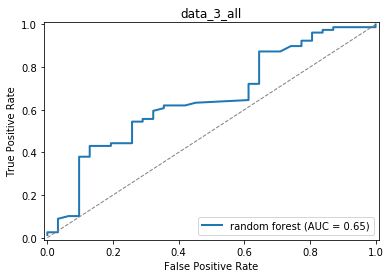

In [5]:
filename='data_3_all'
file=filename+'.csv'
cwd=os.getcwd()
os.chdir('../braindata')
for i in range(5,11):
#     parser = argumentparser()
#     args = parser.parse_args()

    X,y=data_fetch_clean(file,i)
    

#     X,y=data_fetch_clean()
    y = y.reshape(-1)
    name=save_name[i-6]
#     if args.dataset == 1:
    clf_randomforest(X,y,name,filename)
#     elif args.dataset == 2:
#         clf_randomforest(X, y, 1)

In [6]:
#os.chdir('Mor_only_6_25')

# for i in range(6,11):
#         name=save_name[i-6]

#         label=pickle.load(open('roc_label_'+name+'.p',"rb" ) )

#         pred=pickle.load(open('roc_pred_'+name+'.p',"rb" ) )

#         pp=pickle.load(open('roc_prob_'+name+'.p',"rb" ) )

#         import numpy as np 
#         from sklearn.metrics import roc_curve, auc,f1_score
#         import matplotlib.pyplot as plt
#         fpr = dict()
#         tpr = dict()
#         roc_auc = dict()

#         fpr, tpr, _ = roc_curve(label, pp)
#         roc_auc = auc(fpr, tpr)

#         plt.figure()
#         plt.plot(fpr, tpr, lw=5, label='Random Forest(area = %0.2f)' % roc_auc)

#         plt.plot([0, 1], [0, 1], color='navy', lw=5, linestyle='--')
#         plt.xlim([0.0, 1.0])
#         plt.ylim([0.0, 1.0])
#         plt.xlabel('False Positive Rate')
#         plt.ylabel('True Positive Rate')
#         plt.title(name)
#         plt.legend(loc="lower right") 
#         roc_path="ROC_"+name+"_connectome.pdf"
#         plt.savefig(roc_path)